<a href="https://colab.research.google.com/github/tirals88/predicting_pm2.5/blob/main/August/PM_pred_new2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. 주변 5개의 AWS 데이터 사용

이전까지 AIFactory 문제에서는 input data scale : 261 or 167 columns (위/경도 데이터 차이)

167columns : 5개의 AWS관측소 (기온(°C)	풍향(deg)	풍속(m/s)	강수량(mm)	습도(%)) 총 5개의 AWS data + 17개의 PM2.5 관측소의 PM2.5 data

이는 총 47개의 관측데이터를 통해 17개의 PM2.5 관측소의 동시 예측을 해야하는 문제

위 문제를 아래 세 가지로 변경할 계획

1. ~~30개의 AWS 관측소 + 1개의 $A$지역 PM2.5 관측소 -> 1개의 $A$지역 PM2.5 관측소 예측~~
2. ***$A$지역 PM2.5 관측소 기준 반경 $X$ 내의 AWS 관측소 -> $A$지역 PM2.5 관측소 예측***
3. (2)의 input 데이터 + 반경 $Y$ 내의 PM2.5 관측소

$X와 Y$는 위/경도를 기준으로 할 수 있음

https://www.airkorea.or.kr/web/dustForecast?pMENU_NO=113
환경부 PM2.5 예측을 보면 이틀치의 예측을 하기에 위 세 문제도 48hours 이하의 ouput time steps를 가질 것임

input time steps를 정하는 기준은 data의 비교를 통해 결정 할 예정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### PM2.5 관측소 신방동 (36.7823546, 127.1205056) 기준 가까운 5개 AWS 관측소 찾기

In [ ]:
aws_data = '/content/drive/MyDrive/AIFactory/dataset/META/awsmap.csv'

awsmap = pd.read_csv(aws_data)

awsmap_2 = awsmap.iloc[:, 1:3]
awsmap_2
awsmap_2.iloc[0, 0]
len(awsmap_2)

30

In [ ]:
pmmap = [36.7823546, 127.1205056]
def length(pm, aws):
  lat_0 = pm[0]
  long_0 = pm[1]
  lenlist = []
  for i in range(len(aws)):
    lat_1 = np.square(lat_0 - aws.iloc[i,0])
    long_1 = np.square(long_0 - aws.iloc[i, 1])
    lenlist.append(lat_1+long_1)


  lenlist = pd.DataFrame(lenlist, columns = ['length'])
  return lenlist

maplist = length(pmmap, awsmap.iloc[:, 1:3])
maplist = maplist.sort_values(by='length', ascending=True)
maplist[:5].index.values

array([16,  6, 21, 22,  5])

In [ ]:
awsmap.iloc[maplist[:5].index.values]

,Location,Latitude,Longitude,Description
16,성거,36.8782,127.1561,충청남도 천안시서북구 성거읍봉주로 75(서북구청)
6,세종전의,36.6908,127.2005,세종특별자치시 전의면읍내리 5-1번지(전의생활체육공원)
21,정안,36.5511,127.0938,충청남도 공주시정안면 평정리284-5
22,아산,36.8458,126.8654,충청남도 아산시인주면 현대로1077(현대자동차㈜ 아산공장)
5,세종연서,36.5667,127.2806,세종특별자치시 연서면봉암리 196-1


In [ ]:
awsmap = awsmap.iloc[maplist[:5].index.values]

In [ ]:
awsloc = awsmap.iloc[:, 0].values
awsloc

array(['성거', '세종전의', '정안', '아산', '세종연서'], dtype=object)

In [ ]:
aloc = []
for i in range(5):
  aloc.append(awsloc[i]+'.csv')
aloc

['성거.csv', '세종전의.csv', '정안.csv', '아산.csv', '세종연서.csv']

In [ ]:
### 데이터 합치기
data = '/content/drive/MyDrive/AIFactory/dataset'
file_type = ['/TRAIN', '/TRAIN_AWS', '/TEST_INPUT', '/TEST_AWS']
#train_list = os.listdir(data+file_type[0])
train_AWS_list = ['공주.csv', '계룡.csv', '논산.csv', '성거.csv', '북격렬비도.csv', '세종고운.csv', '당진.csv']

for i in range(len(aloc)):
  globals()["aws_{}".format(i)] = pd.read_csv(data+file_type[1]+'/'+aloc[i]).interpolate()
  #print(globals()["aws_{}".format(i)].isna().sum())

In [ ]:
aws_0

,연도,일시,지점,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%)
0,0,01-01 00:00,성거,0.157978,0.012500,0.012788,0.0,0.615
1,0,01-01 01:00,성거,0.153239,0.000000,0.007673,0.0,0.593
2,0,01-01 02:00,성거,0.137441,0.000000,0.010230,0.0,0.674
3,0,01-01 03:00,성거,0.115324,0.000000,0.010230,0.0,0.705
4,0,01-01 04:00,성거,0.112164,0.000000,0.000000,0.0,0.732
...,...,...,...,...,...,...,...,...
35059,3,12-31 19:00,성거,0.271722,0.867778,0.043478,0.0,0.534
35060,3,12-31 20:00,성거,0.260664,0.907500,0.035806,0.0,0.568
35061,3,12-31 21:00,성거,0.246445,0.043889,0.023018,0.0,0.537
35062,3,12-31 22:00,성거,0.236967,0.003889,0.025575,0.0,0.542


In [ ]:
del aws_0['연도']
del aws_0['일시']
del aws_0['지점']

In [ ]:
aws_full = aws_0
for i in range(1, 5):
  del globals()["aws_{}".format(i)]['연도']
  del globals()["aws_{}".format(i)]['일시']
  del globals()["aws_{}".format(i)]['지점']
  aws_full = pd.concat([aws_full, globals()["aws_{}".format(i)]], axis=1)

In [ ]:
aws_full

,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),...,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%)
0,0.157978,0.012500,0.012788,0.0,0.615,0.164297,0.958056,0.033248,0.0,0.752,...,0.191153,0.083056,0.076726,0.0,0.501,0.173776,0.011389,0.025575,0.0,0.741
1,0.153239,0.000000,0.007673,0.0,0.593,0.145340,0.077778,0.015345,0.0,0.748,...,0.184834,0.086667,0.048593,0.0,0.547,0.173776,0.943889,0.023018,0.0,0.737
2,0.137441,0.000000,0.010230,0.0,0.674,0.118483,0.893333,0.017903,0.0,0.770,...,0.181675,0.087222,0.025575,0.0,0.570,0.165877,0.000000,0.000000,0.0,0.779
3,0.115324,0.000000,0.010230,0.0,0.705,0.082148,0.042500,0.023018,0.0,0.774,...,0.173776,0.424722,0.028133,0.0,0.627,0.148499,0.000000,0.007673,0.0,0.800
4,0.112164,0.000000,0.000000,0.0,0.732,0.056872,0.045000,0.015345,0.0,0.822,...,0.170616,0.000000,0.010230,0.0,0.689,0.126382,0.963889,0.030691,0.0,0.853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,0.271722,0.867778,0.043478,0.0,0.534,0.271722,0.979167,0.063939,0.0,0.642,...,0.289100,0.881111,0.117647,0.0,0.590,0.273302,0.884444,0.035806,0.0,0.587
35060,0.260664,0.907500,0.035806,0.0,0.568,0.254344,0.892500,0.081841,0.0,0.597,...,0.276461,0.890000,0.132992,0.0,0.655,0.273302,0.975556,0.051151,0.0,0.638
35061,0.246445,0.043889,0.023018,0.0,0.537,0.241706,0.033056,0.094629,0.0,0.593,...,0.260664,0.796667,0.102302,0.0,0.580,0.252765,0.971944,0.046036,0.0,0.618
35062,0.236967,0.003889,0.025575,0.0,0.542,0.232227,0.041667,0.079284,0.0,0.578,...,0.254344,0.709722,0.071611,0.0,0.552,0.244866,0.932222,0.071611,0.0,0.602


In [ ]:
#PM_0
pm_0 = pd.read_csv('/content/drive/MyDrive/AIFactory/dataset/TRAIN/신방동.csv')
del pm_0['연도']
del pm_0['일시']
del pm_0['측정소']
train_data = pd.concat([aws_full, pm_0], axis=1)
train_data

,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),...,풍향(deg),풍속(m/s),강수량(mm),습도(%),기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),PM2.5
0,0.157978,0.012500,0.012788,0.0,0.615,0.164297,0.958056,0.033248,0.0,0.752,...,0.083056,0.076726,0.0,0.501,0.173776,0.011389,0.025575,0.0,0.741,0.056
1,0.153239,0.000000,0.007673,0.0,0.593,0.145340,0.077778,0.015345,0.0,0.748,...,0.086667,0.048593,0.0,0.547,0.173776,0.943889,0.023018,0.0,0.737,0.048
2,0.137441,0.000000,0.010230,0.0,0.674,0.118483,0.893333,0.017903,0.0,0.770,...,0.087222,0.025575,0.0,0.570,0.165877,0.000000,0.000000,0.0,0.779,0.048
3,0.115324,0.000000,0.010230,0.0,0.705,0.082148,0.042500,0.023018,0.0,0.774,...,0.424722,0.028133,0.0,0.627,0.148499,0.000000,0.007673,0.0,0.800,0.056
4,0.112164,0.000000,0.000000,0.0,0.732,0.056872,0.045000,0.015345,0.0,0.822,...,0.000000,0.010230,0.0,0.689,0.126382,0.963889,0.030691,0.0,0.853,0.044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,0.271722,0.867778,0.043478,0.0,0.534,0.271722,0.979167,0.063939,0.0,0.642,...,0.881111,0.117647,0.0,0.590,0.273302,0.884444,0.035806,0.0,0.587,0.076
35060,0.260664,0.907500,0.035806,0.0,0.568,0.254344,0.892500,0.081841,0.0,0.597,...,0.890000,0.132992,0.0,0.655,0.273302,0.975556,0.051151,0.0,0.638,0.068
35061,0.246445,0.043889,0.023018,0.0,0.537,0.241706,0.033056,0.094629,0.0,0.593,...,0.796667,0.102302,0.0,0.580,0.252765,0.971944,0.046036,0.0,0.618,0.080
35062,0.236967,0.003889,0.025575,0.0,0.542,0.232227,0.041667,0.079284,0.0,0.578,...,0.709722,0.071611,0.0,0.552,0.244866,0.932222,0.071611,0.0,0.602,0.072


In [ ]:
train_data.columns = np.arange(26)
train_data

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.157978,0.012500,0.012788,0.0,0.615,0.164297,0.958056,0.033248,0.0,0.752,...,0.083056,0.076726,0.0,0.501,0.173776,0.011389,0.025575,0.0,0.741,0.056
1,0.153239,0.000000,0.007673,0.0,0.593,0.145340,0.077778,0.015345,0.0,0.748,...,0.086667,0.048593,0.0,0.547,0.173776,0.943889,0.023018,0.0,0.737,0.048
2,0.137441,0.000000,0.010230,0.0,0.674,0.118483,0.893333,0.017903,0.0,0.770,...,0.087222,0.025575,0.0,0.570,0.165877,0.000000,0.000000,0.0,0.779,0.048
3,0.115324,0.000000,0.010230,0.0,0.705,0.082148,0.042500,0.023018,0.0,0.774,...,0.424722,0.028133,0.0,0.627,0.148499,0.000000,0.007673,0.0,0.800,0.056
4,0.112164,0.000000,0.000000,0.0,0.732,0.056872,0.045000,0.015345,0.0,0.822,...,0.000000,0.010230,0.0,0.689,0.126382,0.963889,0.030691,0.0,0.853,0.044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,0.271722,0.867778,0.043478,0.0,0.534,0.271722,0.979167,0.063939,0.0,0.642,...,0.881111,0.117647,0.0,0.590,0.273302,0.884444,0.035806,0.0,0.587,0.076
35060,0.260664,0.907500,0.035806,0.0,0.568,0.254344,0.892500,0.081841,0.0,0.597,...,0.890000,0.132992,0.0,0.655,0.273302,0.975556,0.051151,0.0,0.638,0.068
35061,0.246445,0.043889,0.023018,0.0,0.537,0.241706,0.033056,0.094629,0.0,0.593,...,0.796667,0.102302,0.0,0.580,0.252765,0.971944,0.046036,0.0,0.618,0.080
35062,0.236967,0.003889,0.025575,0.0,0.542,0.232227,0.041667,0.079284,0.0,0.578,...,0.709722,0.071611,0.0,0.552,0.244866,0.932222,0.071611,0.0,0.602,0.072


# model

In [ ]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Bidirectional, GRU, RepeatVector, Dense, TimeDistributed # for creating layers inside the Neural Network

# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version

# Sklearn
import sklearn
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.preprocessing import MinMaxScaler # for feature scaling

# Visualization
import plotly
import plotly.express as px
import plotly.graph_objects as go
print('plotly: %s' % plotly.__version__) # print version

Tensorflow/Keras: 2.12.0
pandas: 1.5.3
numpy: 1.23.5
sklearn: 1.2.2
plotly: 5.15.0


In [ ]:
def actual_pred_plot(preds, idx):
    """
    Plot the actual vs predition
    """
    actual_pred = pd.DataFrame(columns = ['PM2.5.0', 'prediction'])
    actual_pred['PM2.5.0'] = Y_val[idx, :]
    actual_pred['prediction'] = preds[idx, :]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['PM2.5.0']), np.array(actual_pred['prediction']))

    return (m.result().numpy(), actual_pred.plot())

### model - 4

In [ ]:
#newmodel -1 : scaling / 213columns / 151cols
#newmodel -2 : scaling / 26cols
def split_train_val(train_data_, time_steps, for_periods):
  """
  input:
    data: 날짜를 인덱스로 가지는 AWS 데이터와 PM2.5 데이터
  ouput:
    X_train, Y_train: 0년 1월 1일 00시 ~ 03년 07월 02일 08시 (30681 개의 데이터)
    X_test : 03년 07월 02일 09시부터의 데이터 (4383개의 데이터)
    7:1 비율
  time_steps: # input data time steps : ex)3days/72hours
  for_periods: # output data time steps : ex)2days/48hours
  """
  # training & validation set
  # scale the data
  scaled_AWS = pd.DataFrame(columns=train_data_.columns[:-1])
  scaled_PM = pd.DataFrame(columns=train_data_.columns[-1:])
  sc__ = []

  #X_scaled = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) # X: original data, min: 0, max: 1

  for column in train_data_.columns[:-1]:
    data_ = train_data_[column].interpolate(limit_direction='both').values.reshape((-1, 1))
    scaled_data = ((data_ - data_.min()) / (data_.max()-data_.min())).reshape((len(data_), ))
    scaled_AWS[column] = scaled_data.tolist()
  # Y value / scale
  # for column in train_data_.columns[-1:]:
  #   data_ = train_data_[column].interpolate(limit_direction='both').values.reshape((-1, 1))
  #   scaled_data = ((data_ - data_.min()) / (data_.max()-data_.min())).reshape((len(data_), ))
  #   scaled_PM[column] = scaled_data.tolist()
  #   sc__.append((data_.min(), data_.max()))

  for column in train_data_.columns[-1:]:
    data_ = train_data_[column].interpolate(limit_direction='both').values.reshape((-1, 1))
    scaled_data = data_.reshape((len(data_), ))
    scaled_PM[column] = scaled_data.tolist()

  ## 결측치가 남아있는 경우가 있어서 다시 한 번 보간법 적용
  temp_train_AWS = scaled_AWS[:30682].interpolate(limit_direction='both').values
  temp_train_PM = scaled_PM[:30682].interpolate(limit_direction='both').values

  temp_val_AWS = scaled_AWS[30682:].interpolate(limit_direction='both').values
  temp_val_PM = scaled_PM[30682:].interpolate(limit_direction='both').values

  temp_train_len = len(temp_train_AWS)
  temp_val_len = len(temp_val_AWS)

  temp_train = np.concatenate((temp_train_AWS, temp_train_PM), axis = 1)

  # training data slicing
  X_train = []
  Y_train = []
  Y_train_stacked = []
  for i in range(time_steps, temp_train_len - (for_periods - 1)):

    X_train.append(temp_train[i-time_steps: i, :])
    Y_train.append(temp_train[i:i+for_periods, -1:])
  X_train, Y_train = np.array(X_train), np.array(Y_train)

  #3차원으로 재구성
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 26))
  Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1]))

  #Preparing to creat X_val
  #함수 처음 부분에서 numpy array 로 변동해서 pandas가 아닌 numpy로 concatenate
  inputs_train = np.concatenate((temp_train_AWS, temp_train_PM), axis = 1)
  inputs_val = np.concatenate((temp_val_AWS, temp_val_PM), axis = 1)
  inputs = np.concatenate((inputs_train, inputs_val), axis=0)
  inputs = inputs[len(inputs)- temp_val_len - time_steps : ]
  #inputs = inputs.reshape(-1,1)

  X_val = []
  Y_val = []
  for i in range(time_steps, temp_val_len+time_steps-for_periods+1):
    X_val.append(inputs[i - time_steps:i, :])
    Y_val.append(inputs[i:i+for_periods, -1:])
  X_val, Y_val = np.array(X_val), np.array(Y_val)
  X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 26))
  Y_val = np.reshape(Y_val, (Y_val.shape[0], Y_val.shape[1]))

  return X_train, Y_train, X_val, Y_val, sc__

In [ ]:
X_train, Y_train, X_val, Y_val, sc = split_train_val(train_data, 96, 48)

In [ ]:
X_train.shape

(30539, 96, 26)

In [ ]:
X_train = X_train.astype(float)
Y_train = Y_train.astype(float)
X_val = X_val.astype(float)
Y_val = Y_val.astype(float)

In [ ]:
#GRU_new - 4
def GRU_new4(X_train, Y_train, X_val, sc_):
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, Permute, Flatten, Dropout
    from keras.optimizers import Adam

    # The GRU architecture
    my_GRU_model = Sequential()
    #my_GRU_model.add(keras.layers.Flatten())
    my_GRU_model.add(GRU(units = 50,
                         return_sequences = True,
                         input_shape = ((96, 26)),
                         activation = 'tanh'))

    my_GRU_model.add(GRU(units = 50,
                         return_sequences = True,
                         activation = 'tanh'))

    my_GRU_model.add(GRU(units = 50,
                         activation = 'tanh'))

    #my_GRU_model.add(Flatten()) ## return_sequence = True (output shape = 3d), False (output shape = 2d)

    my_GRU_model.add(Dense(units = 48))

    # Compiling the RNN
    my_GRU_model.compile(optimizer = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
                         loss = 'mean_squared_error')
    # Fitting to the trainig set
    history = my_GRU_model.fit(X_train, Y_train, epochs = 8, batch_size = 100, verbose = 1, validation_data=(X_val, Y_val))

    GRU_prediction = my_GRU_model.predict(X_val)
    print(GRU_prediction.shape)
    #GRU_prediction = sc_.inverse_transform(GRU_prediction)
    #GRU_prediction[:, :] = ((GRU_prediction[:, :] - sc[0][0])/(sc[0][1] - sc[0][0]))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(['train','val'])
    plt.show()
    return my_GRU_model, GRU_prediction

# (batch_size, time_seq, features)

Epoch 1/8
306/306 [==============================] - 11s 17ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 2/8
306/306 [==============================] - 4s 12ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 3/8
306/306 [==============================] - 4s 14ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 4/8
306/306 [==============================] - 4s 14ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 5/8
306/306 [==============================] - 4s 13ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 6/8
306/306 [==============================] - 4s 13ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 7/8
306/306 [==============================] - 5s 16ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 8/8
136/136 [==============================] - 2s 6ms/step
(4335, 48)


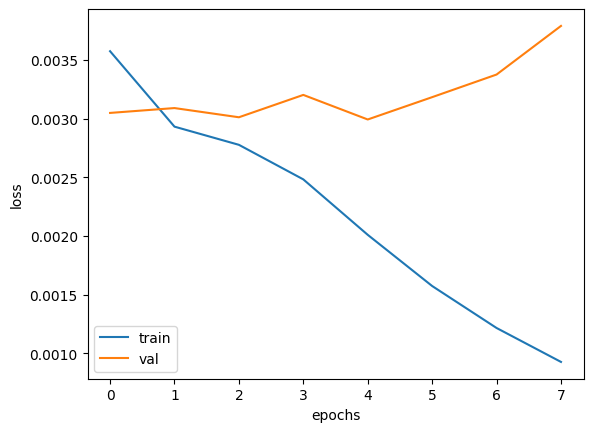

In [ ]:
my_GRU_model4, GRU_prediction4 = GRU_new4(X_train, Y_train, X_val, sc)

In [ ]:
GRU_prediction4

array([[0.07070723, 0.0832091 , 0.06897377, ..., 0.05018258, 0.05630103,
        0.05462895],
       [0.06912758, 0.08116357, 0.06695191, ..., 0.05026409, 0.05740866,
        0.05541106],
       [0.07266984, 0.08261498, 0.06826159, ..., 0.05400888, 0.06127681,
        0.05991204],
       ...,
       [0.2099506 , 0.20814517, 0.18895811, ..., 0.10686705, 0.09548   ,
        0.10623461],
       [0.20767704, 0.20538133, 0.1813756 , ..., 0.1106292 , 0.09819362,
        0.11213228],
       [0.21198013, 0.20919895, 0.18027797, ..., 0.11452758, 0.10186228,
        0.11989428]], dtype=float32)

In [ ]:
Y_val

array([[0.088, 0.096, 0.1  , ..., 0.048, 0.024, 0.028],
       [0.096, 0.1  , 0.088, ..., 0.024, 0.028, 0.048],
       [0.1  , 0.088, 0.096, ..., 0.028, 0.048, 0.052],
       ...,
       [0.292, 0.308, 0.3  , ..., 0.076, 0.068, 0.08 ],
       [0.308, 0.3  , 0.324, ..., 0.068, 0.08 , 0.072],
       [0.3  , 0.324, 0.308, ..., 0.08 , 0.072, 0.076]])

(0.00046654325, <Axes: >)

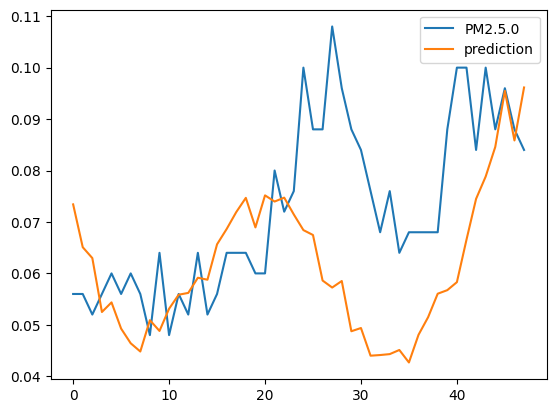

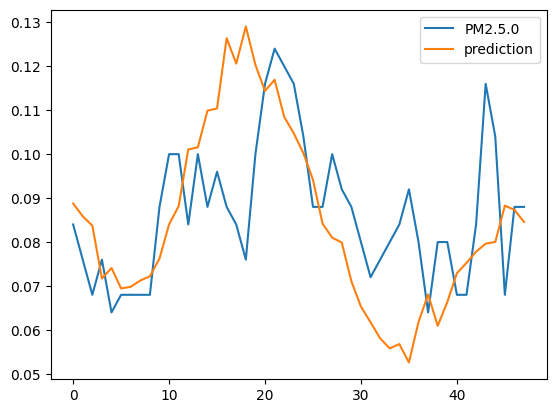

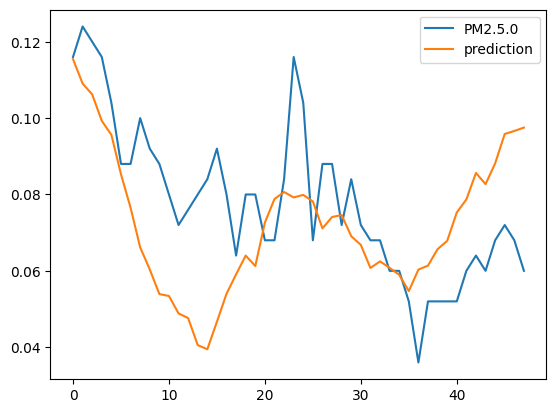

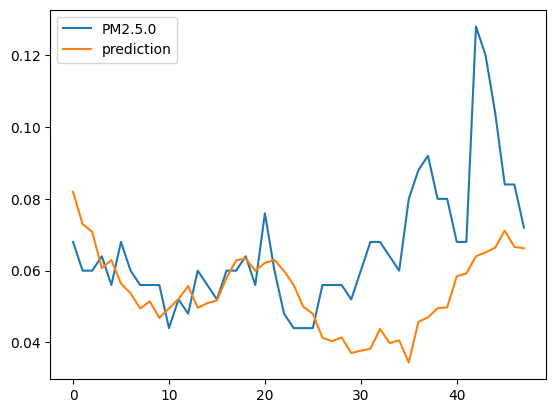

In [ ]:
actual_pred_plot(GRU_prediction4, 200)
actual_pred_plot(GRU_prediction4, 230)
actual_pred_plot(GRU_prediction4, 250)
actual_pred_plot(GRU_prediction4, 300)

(0.0009432298, <Axes: >)

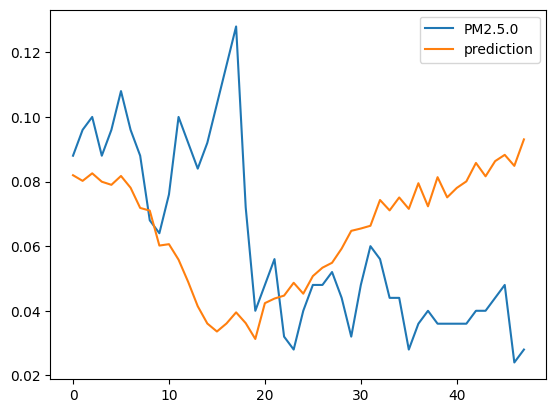

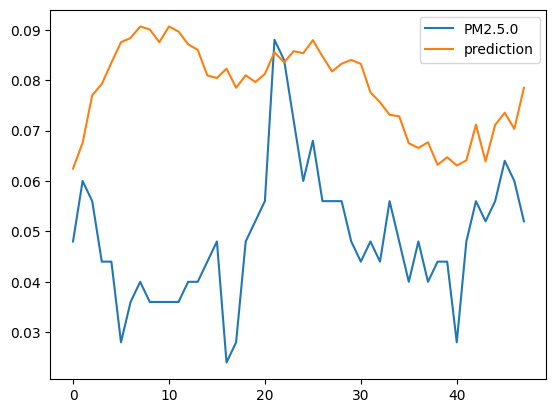

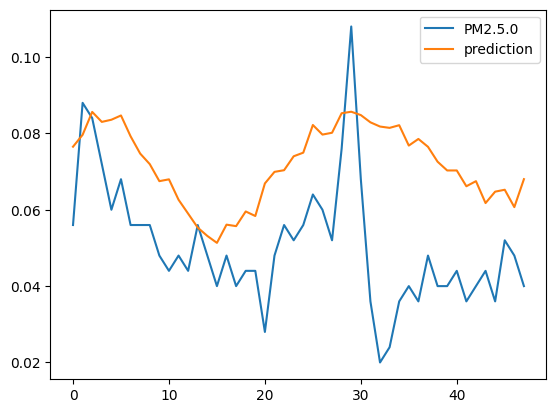

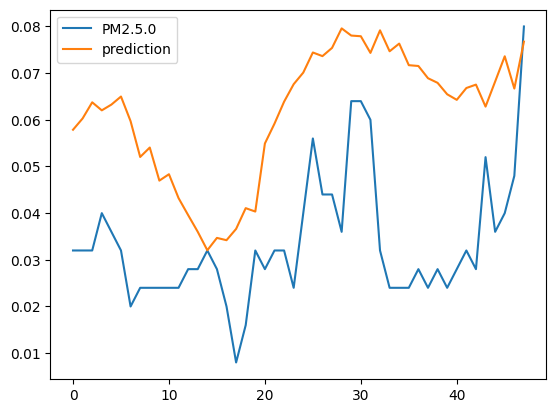

In [ ]:
actual_pred_plot(GRU_prediction4, 0)
actual_pred_plot(GRU_prediction4, 30)
actual_pred_plot(GRU_prediction4, 50)
actual_pred_plot(GRU_prediction4, 100)

### model - 4.1
 data 형태를 [기온0 ~ 4, 풍향0 ~ 4, ..., 습도0 ~ 4] 순으로 바꿀 때

In [ ]:
aws_full2 = aws_full.copy()
temp_idx = []
for i in range(5):
  temp_idx.append(0 + i)
  temp_idx.append(5 + i)
  temp_idx.append(10 + i)
  temp_idx.append(15 + i)
  temp_idx.append(20 + i)
aws_full2 = aws_full2.iloc[:, temp_idx]
aws_full2

,기온(°C),기온(°C),기온(°C),기온(°C),기온(°C),풍향(deg),풍향(deg),풍향(deg),풍향(deg),풍향(deg),...,강수량(mm),강수량(mm),강수량(mm),강수량(mm),강수량(mm),습도(%),습도(%),습도(%),습도(%),습도(%)
0,0.157978,0.164297,0.134281,0.191153,0.173776,0.012500,0.958056,0.000000,0.083056,0.011389,...,0.0,0.0,0.0,0.0,0.0,0.615,0.752,0.796,0.501,0.741
1,0.153239,0.145340,0.151659,0.184834,0.173776,0.000000,0.077778,0.000000,0.086667,0.943889,...,0.0,0.0,0.0,0.0,0.0,0.593,0.748,0.795,0.547,0.737
2,0.137441,0.118483,0.165877,0.181675,0.165877,0.000000,0.893333,0.000000,0.087222,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.674,0.770,0.772,0.570,0.779
3,0.115324,0.082148,0.162717,0.173776,0.148499,0.000000,0.042500,0.000000,0.424722,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.705,0.774,0.746,0.627,0.800
4,0.112164,0.056872,0.139021,0.170616,0.126382,0.000000,0.045000,0.697500,0.000000,0.963889,...,0.0,0.0,0.0,0.0,0.0,0.732,0.822,0.770,0.689,0.853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,0.271722,0.271722,0.282780,0.289100,0.273302,0.867778,0.979167,0.858056,0.881111,0.884444,...,0.0,0.0,0.0,0.0,0.0,0.534,0.642,0.586,0.590,0.587
35060,0.260664,0.254344,0.274882,0.276461,0.273302,0.907500,0.892500,0.888611,0.890000,0.975556,...,0.0,0.0,0.0,0.0,0.0,0.568,0.597,0.624,0.655,0.638
35061,0.246445,0.241706,0.266983,0.260664,0.252765,0.043889,0.033056,0.945833,0.796667,0.971944,...,0.0,0.0,0.0,0.0,0.0,0.537,0.593,0.637,0.580,0.618
35062,0.236967,0.232227,0.257504,0.254344,0.244866,0.003889,0.041667,0.836667,0.709722,0.932222,...,0.0,0.0,0.0,0.0,0.0,0.542,0.578,0.667,0.552,0.602


In [ ]:
#PM_0

train_data_2 = pd.concat([aws_full2, pm_0], axis=1)
train_data_2.columns = np.arange(26)
train_data_2

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.157978,0.164297,0.134281,0.191153,0.173776,0.012500,0.958056,0.000000,0.083056,0.011389,...,0.0,0.0,0.0,0.0,0.615,0.752,0.796,0.501,0.741,0.056
1,0.153239,0.145340,0.151659,0.184834,0.173776,0.000000,0.077778,0.000000,0.086667,0.943889,...,0.0,0.0,0.0,0.0,0.593,0.748,0.795,0.547,0.737,0.048
2,0.137441,0.118483,0.165877,0.181675,0.165877,0.000000,0.893333,0.000000,0.087222,0.000000,...,0.0,0.0,0.0,0.0,0.674,0.770,0.772,0.570,0.779,0.048
3,0.115324,0.082148,0.162717,0.173776,0.148499,0.000000,0.042500,0.000000,0.424722,0.000000,...,0.0,0.0,0.0,0.0,0.705,0.774,0.746,0.627,0.800,0.056
4,0.112164,0.056872,0.139021,0.170616,0.126382,0.000000,0.045000,0.697500,0.000000,0.963889,...,0.0,0.0,0.0,0.0,0.732,0.822,0.770,0.689,0.853,0.044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,0.271722,0.271722,0.282780,0.289100,0.273302,0.867778,0.979167,0.858056,0.881111,0.884444,...,0.0,0.0,0.0,0.0,0.534,0.642,0.586,0.590,0.587,0.076
35060,0.260664,0.254344,0.274882,0.276461,0.273302,0.907500,0.892500,0.888611,0.890000,0.975556,...,0.0,0.0,0.0,0.0,0.568,0.597,0.624,0.655,0.638,0.068
35061,0.246445,0.241706,0.266983,0.260664,0.252765,0.043889,0.033056,0.945833,0.796667,0.971944,...,0.0,0.0,0.0,0.0,0.537,0.593,0.637,0.580,0.618,0.080
35062,0.236967,0.232227,0.257504,0.254344,0.244866,0.003889,0.041667,0.836667,0.709722,0.932222,...,0.0,0.0,0.0,0.0,0.542,0.578,0.667,0.552,0.602,0.072


In [ ]:
X_train, Y_train, X_val, Y_val, sc = split_train_val(train_data_2, 96, 48)

In [ ]:
X_train = X_train.astype(float)
Y_train = Y_train.astype(float)
X_val = X_val.astype(float)
Y_val = Y_val.astype(float)

Epoch 1/8
306/306 [==============================] - 10s 17ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 2/8
306/306 [==============================] - 5s 17ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 3/8
306/306 [==============================] - 4s 12ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 4/8
306/306 [==============================] - 4s 15ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 5/8
306/306 [==============================] - 6s 19ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 6/8
306/306 [==============================] - 4s 14ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 7/8
306/306 [==============================] - 6s 19ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 8/8
136/136 [==============================] - 3s 9ms/step
(4335, 48)


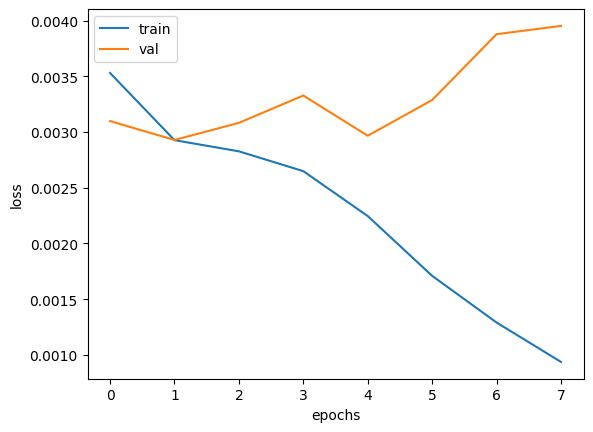

In [ ]:
my_GRU_model4, GRU_prediction4 = GRU_new4(X_train, Y_train, X_val, sc)

(0.00082485215, <Axes: >)

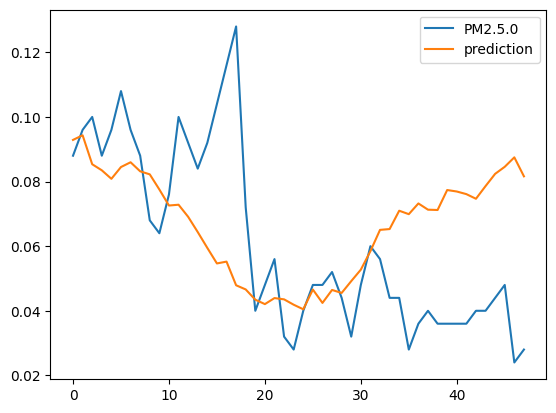

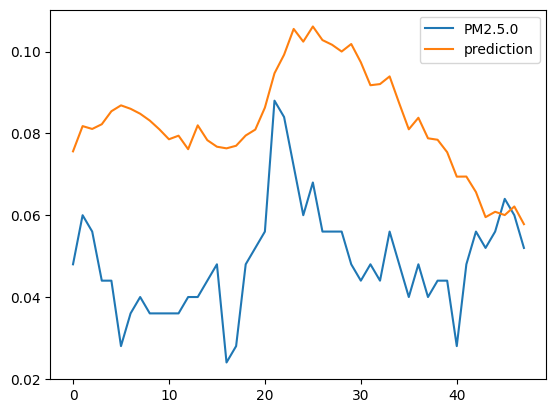

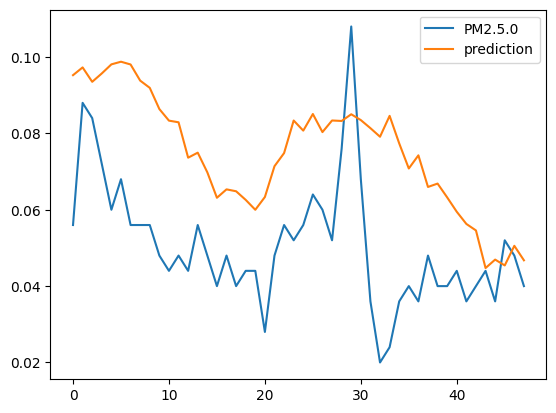

In [ ]:
actual_pred_plot(GRU_prediction4, 0)
actual_pred_plot(GRU_prediction4, 30)
actual_pred_plot(GRU_prediction4, 50)

(0.00034829043, <Axes: >)

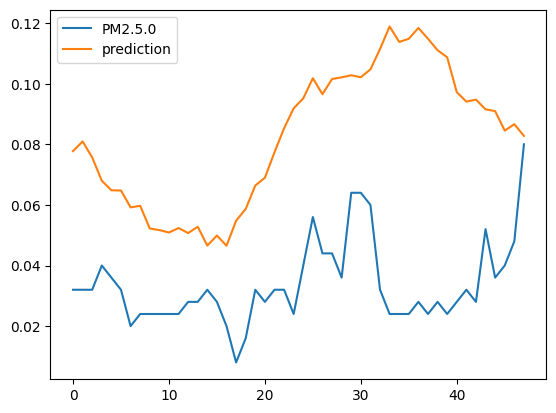

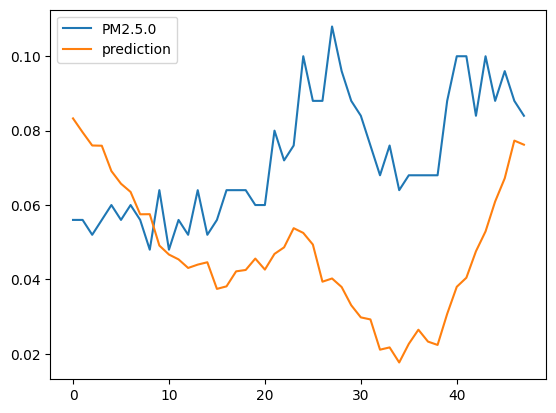

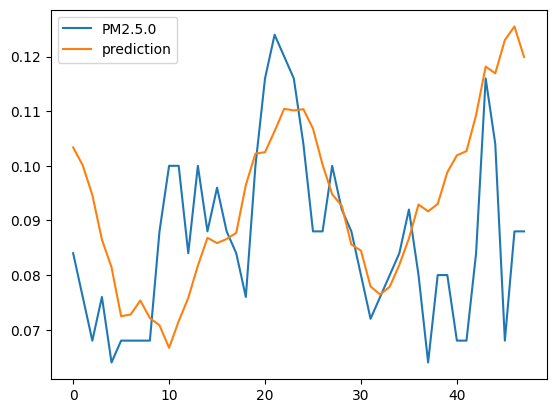

In [ ]:
actual_pred_plot(GRU_prediction4, 100)
actual_pred_plot(GRU_prediction4, 200)
actual_pred_plot(GRU_prediction4, 230)

(0.0012998944, <Axes: >)

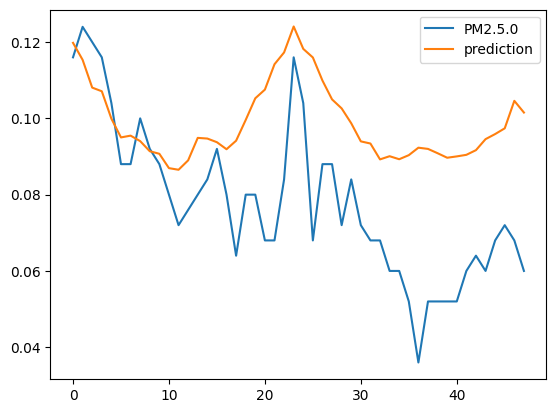

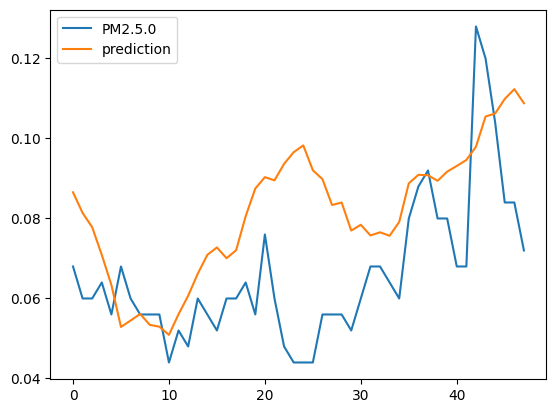

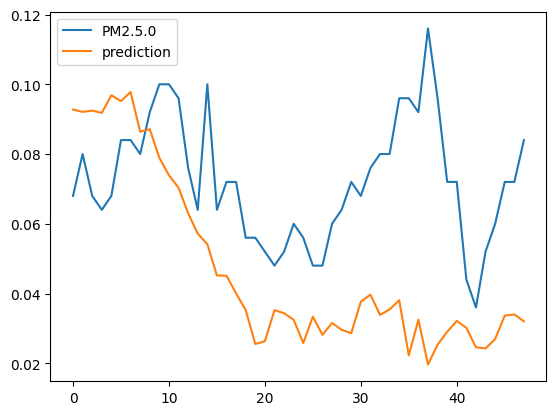

In [ ]:
actual_pred_plot(GRU_prediction4, 250)
actual_pred_plot(GRU_prediction4, 300)
actual_pred_plot(GRU_prediction4, 400)

(0.004350082, <Axes: >)

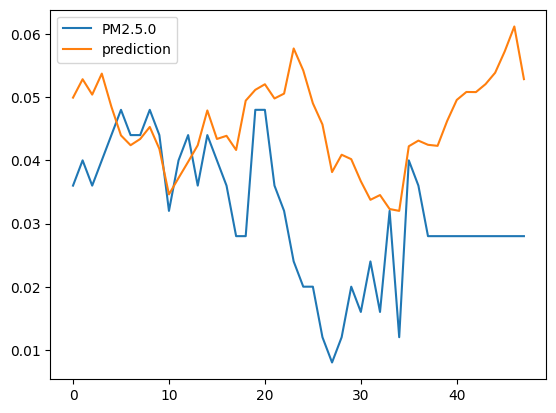

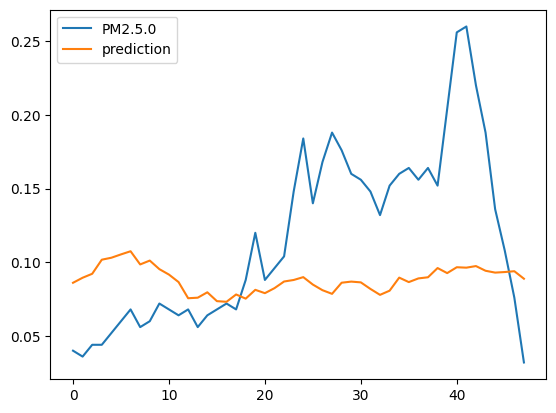

In [ ]:
actual_pred_plot(GRU_prediction4, 1500)
actual_pred_plot(GRU_prediction4, 2500)

### model - 5

In [ ]:
#GRU_new - 5
def GRU_new5(X_train, Y_train, X_val, sc_):
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, Permute, Flatten, Dropout
    from keras.optimizers import Adam

    # The GRU architecture
    my_GRU_model = Sequential()
    #my_GRU_model.add(keras.layers.Flatten())
    my_GRU_model.add(GRU(units = 100,
                         return_sequences = True,
                         input_shape = ((96, 26)),
                         activation = 'tanh'))

    my_GRU_model.add(GRU(units = 200,
                         return_sequences = True,
                         activation = 'tanh'))

    my_GRU_model.add(GRU(units = 100,
                         activation = 'tanh'))

    #my_GRU_model.add(Flatten()) ## return_sequence = True (output shape = 3d), False (output shape = 2d)

    my_GRU_model.add(Dense(units = 48))

    # Compiling the RNN
    my_GRU_model.compile(optimizer = Adam(learning_rate=0.008, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False),
                         loss = 'mean_squared_error')
    # Fitting to the trainig set
    history = my_GRU_model.fit(X_train, Y_train, epochs = 8, batch_size = 100, verbose = 1, validation_data=(X_val, Y_val))

    GRU_prediction = my_GRU_model.predict(X_val)
    print(GRU_prediction.shape)
    #GRU_prediction = sc_.inverse_transform(GRU_prediction)
    #GRU_prediction[:, :] = ((GRU_prediction[:, :] - sc[0][0])/(sc[0][1] - sc[0][0]))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(['train','val'])
    plt.show()
    return my_GRU_model, GRU_prediction

# (batch_size, time_seq, features)

Epoch 1/8
306/306 [==============================] - 11s 24ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 2/8
306/306 [==============================] - 6s 20ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 3/8
306/306 [==============================] - 6s 20ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 4/8
306/306 [==============================] - 6s 20ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 5/8
306/306 [==============================] - 6s 21ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 6/8
306/306 [==============================] - 6s 20ms/step - loss: 8.3124e-04 - val_loss: 0.0037
Epoch 7/8
306/306 [==============================] - 6s 21ms/step - loss: 5.8958e-04 - val_loss: 0.0039
Epoch 8/8
136/136 [==============================] - 3s 6ms/step
(4335, 48)


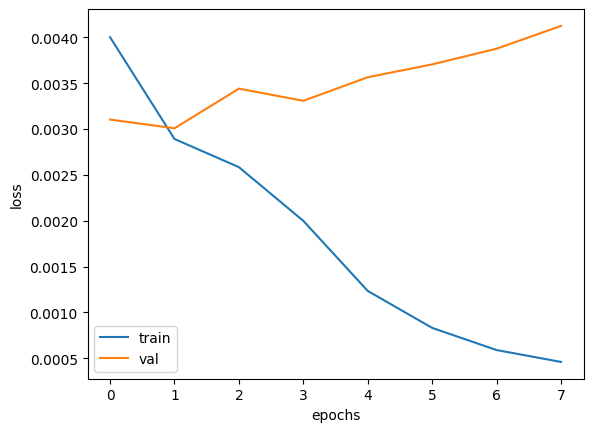

In [ ]:
my_GRU_model5, GRU_prediction5 = GRU_new5(X_train, Y_train, X_val, sc)

(0.0003915388, <Axes: >)

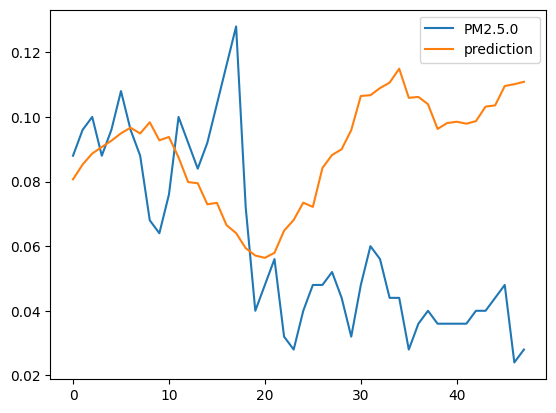

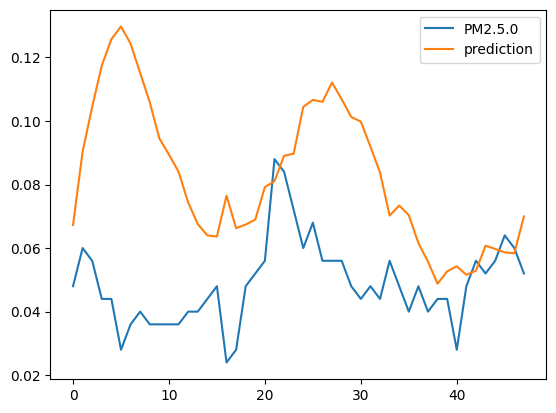

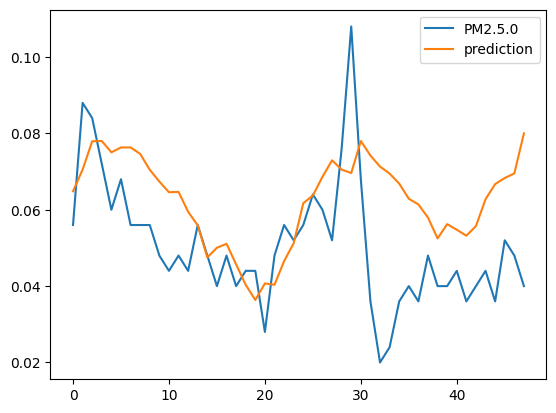

In [ ]:
actual_pred_plot(GRU_prediction5, 0)
actual_pred_plot(GRU_prediction5, 30)
actual_pred_plot(GRU_prediction5, 50)

(0.00045671957, <Axes: >)

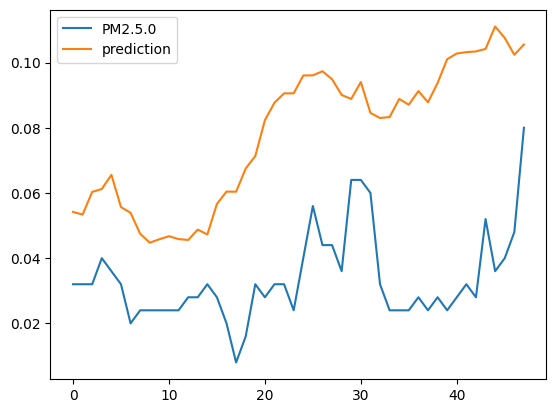

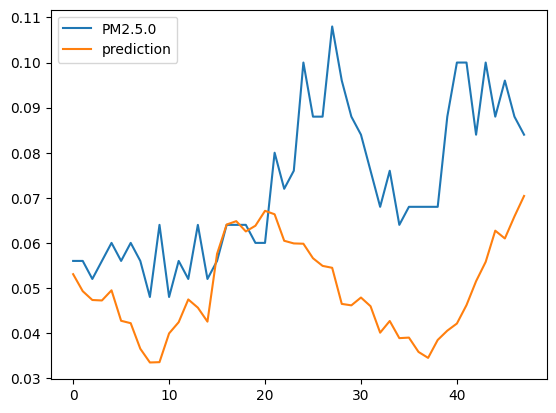

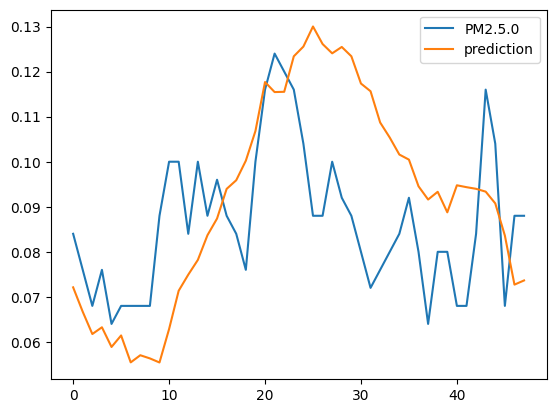

In [ ]:
actual_pred_plot(GRU_prediction5, 100)
actual_pred_plot(GRU_prediction5, 200)
actual_pred_plot(GRU_prediction5, 230)

(0.00029047034, <Axes: >)

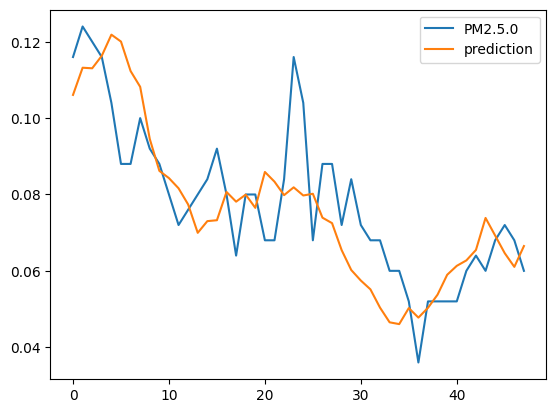

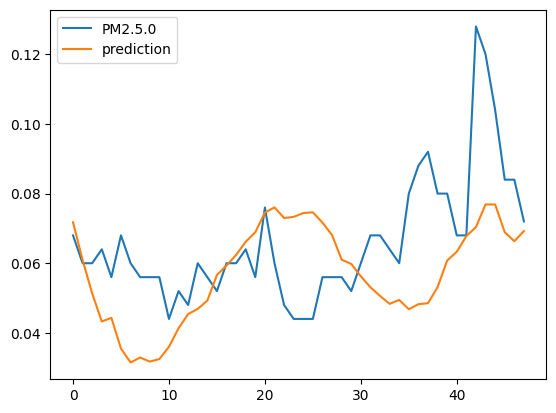

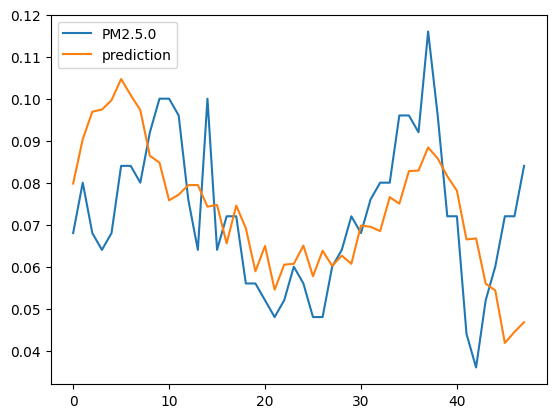

In [ ]:
actual_pred_plot(GRU_prediction5, 250)
actual_pred_plot(GRU_prediction5, 300)
actual_pred_plot(GRU_prediction5, 400)

In [ ]:
from keras.models import load_model

my_GRU_model5.save('/content/drive/MyDrive/colabnotebooks/data/GRU_0.h5')

In [ ]:
GRU_prediction5

array([[0.08068281, 0.08527102, 0.08867003, ..., 0.1095728 , 0.11013496,
        0.11086982],
       [0.09106359, 0.09284231, 0.09507775, ..., 0.11500631, 0.11488769,
        0.11732367],
       [0.09896664, 0.09768848, 0.09866124, ..., 0.11712821, 0.11579251,
        0.11798861],
       ...,
       [0.2528984 , 0.22252233, 0.21169534, ..., 0.15308604, 0.16484189,
        0.15408048],
       [0.25098342, 0.22035594, 0.21044102, ..., 0.15746157, 0.16741866,
        0.15254283],
       [0.2695204 , 0.23835073, 0.22582895, ..., 0.16913757, 0.17098287,
        0.1554559 ]], dtype=float32)

In [ ]:
np.save('/content/drive/MyDrive/colabnotebooks/data/GRU_0.npy', GRU_prediction5)

### model - 6

In [ ]:
#GRU_new - 6
def GRU_new6(X_train, Y_train, X_val, sc_):
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, Permute, Flatten, Dropout
    from keras.optimizers import Adam

    # The GRU architecture
    my_GRU_model = Sequential()
    #my_GRU_model.add(keras.layers.Flatten())
    my_GRU_model.add(GRU(units = 100,
                         dropout=0.2,
                         return_sequences = True,
                         input_shape = ((96, 26)),
                         activation = 'tanh'))

    my_GRU_model.add(GRU(units = 200,
                         return_sequences = True,
                         activation = 'tanh'))

    my_GRU_model.add(GRU(units = 100,
                         activation = 'tanh'))

    #my_GRU_model.add(Flatten()) ## return_sequence = True (output shape = 3d), False (output shape = 2d)

    my_GRU_model.add(Dense(units = 48))

    # Compiling the RNN
    my_GRU_model.compile(optimizer = Adam(learning_rate=0.008, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=True),
                         loss = 'mean_squared_error')
    # Fitting to the trainig set
    history = my_GRU_model.fit(X_train, Y_train, epochs = 8, batch_size = 100, verbose = 1, validation_data=(X_val, Y_val))

    GRU_prediction = my_GRU_model.predict(X_val)
    print(GRU_prediction.shape)
    #GRU_prediction = sc_.inverse_transform(GRU_prediction)
    #GRU_prediction[:, :] = ((GRU_prediction[:, :] - sc[0][0])/(sc[0][1] - sc[0][0]))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(['train','val'])
    plt.show()
    return my_GRU_model, GRU_prediction

# (batch_size, time_seq, features)

Epoch 1/8
306/306 [==============================] - 12s 25ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 2/8
306/306 [==============================] - 6s 20ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 3/8
306/306 [==============================] - 6s 20ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 4/8
306/306 [==============================] - 6s 20ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 5/8
306/306 [==============================] - 6s 20ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 6/8
306/306 [==============================] - 6s 21ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 7/8
306/306 [==============================] - 6s 20ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 8/8
136/136 [==============================] - 2s 7ms/step
(4335, 48)


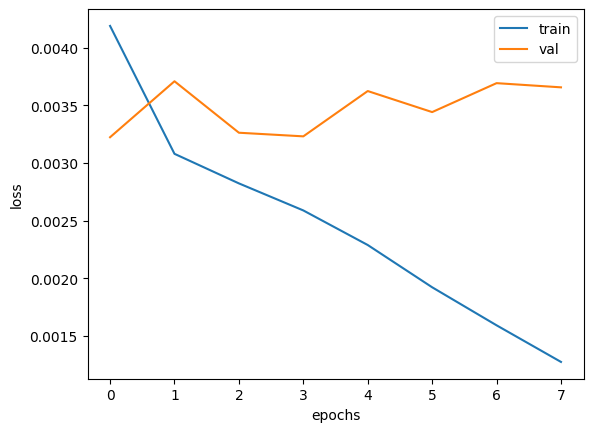

In [ ]:
my_GRU_model6, GRU_prediction6 = GRU_new6(X_train, Y_train, X_val, sc)

(0.00044814203, <Axes: >)

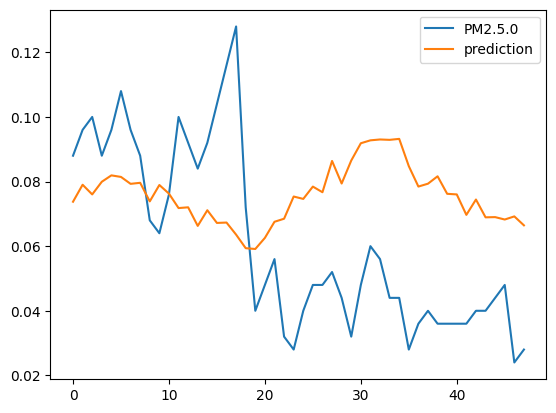

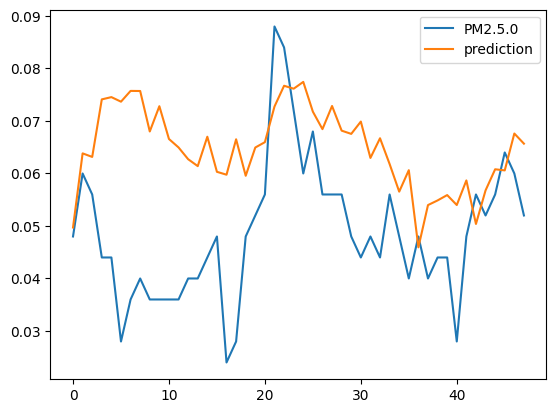

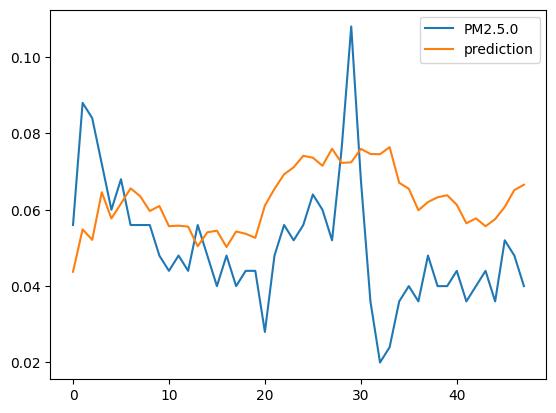

In [ ]:
actual_pred_plot(GRU_prediction6, 0)
actual_pred_plot(GRU_prediction6, 30)
actual_pred_plot(GRU_prediction6, 50)

(0.0005961025, <Axes: >)

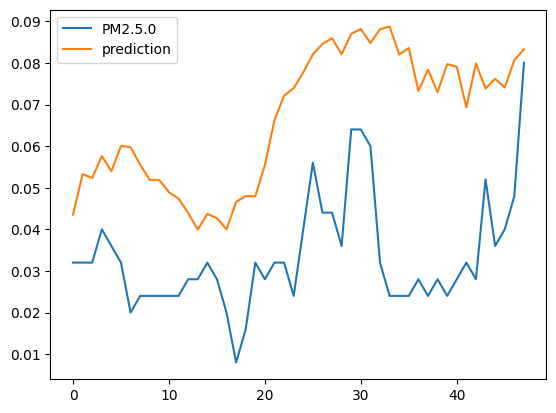

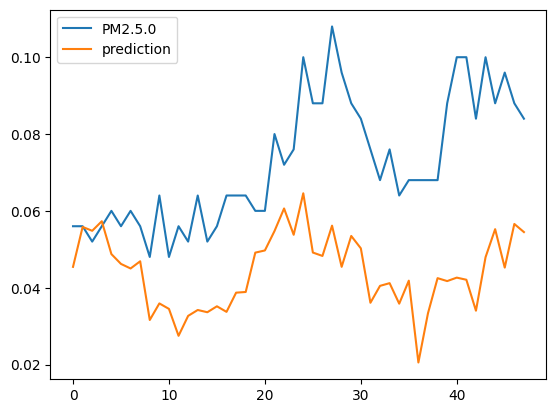

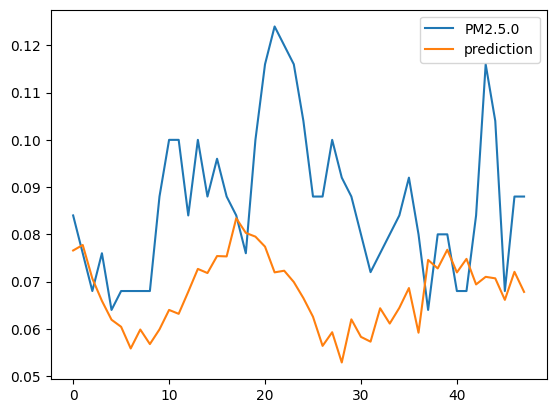

In [ ]:
actual_pred_plot(GRU_prediction6, 100)
actual_pred_plot(GRU_prediction6, 200)
actual_pred_plot(GRU_prediction6, 230)

(0.0005364094, <Axes: >)

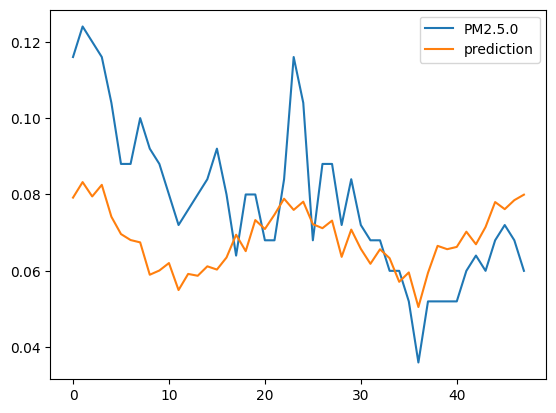

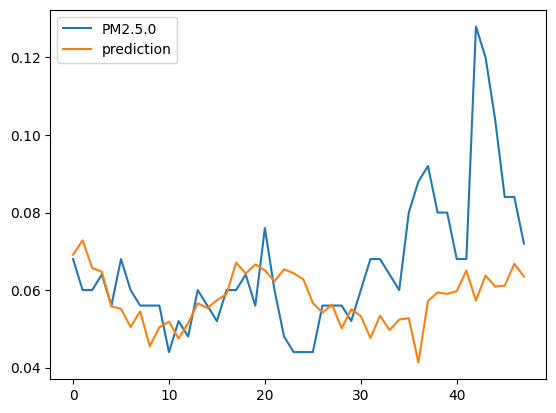

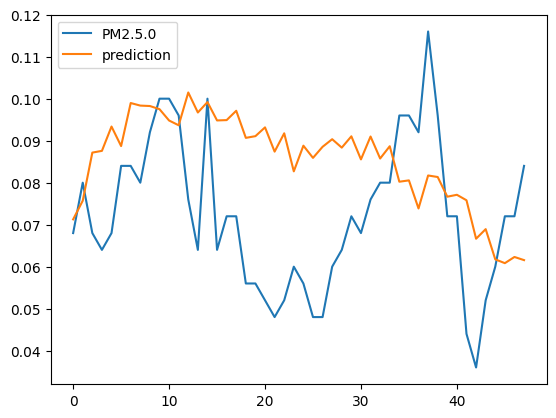

In [ ]:
actual_pred_plot(GRU_prediction6, 250)
actual_pred_plot(GRU_prediction6, 300)
actual_pred_plot(GRU_prediction6, 400)